In [6]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

[*********************100%***********************]  1 of 1 completed


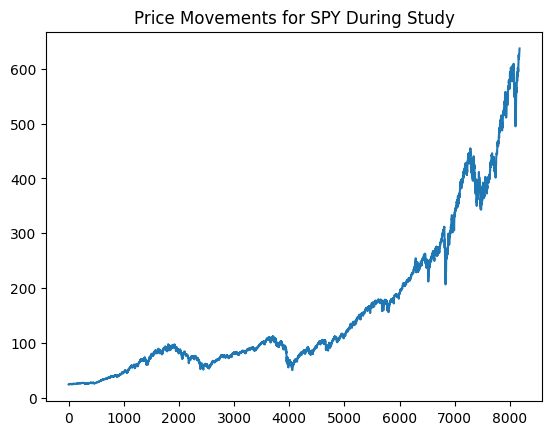

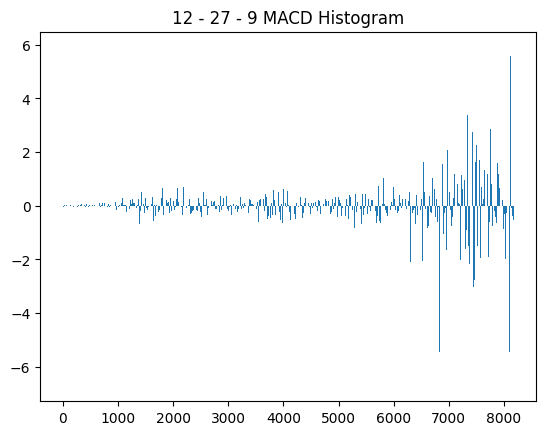

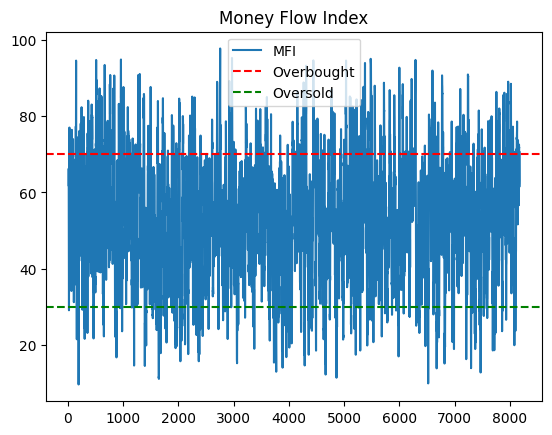

Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC: 0.5292
Shift:  2 | AUC: 0.5112
Shift:  3 | AUC: 0.5192
Shift:  4 | AUC: 0.5185
Shift:  5 | AUC: 0.5203
Shift:  6 | AUC: 0.5238
Shift:  7 | AUC: 0.5333
Shift:  8 | AUC: 0.5344
Shift:  9 | AUC: 0.5347
Shift: 10 | AUC: 0.5367
Shift: 11 | AUC: 0.5322
Shift: 12 | AUC: 0.5322
Shift: 13 | AUC: 0.5319
Shift: 14 | AUC: 0.5270
Shift: 15 | AUC: 0.5193
Shift: 16 | AUC: 0.5204
Shift: 17 | AUC: 0.5183
Shift: 18 | AUC: 0.5218
Shift: 19 | AUC: 0.5221
Shift: 20 | AUC: 0.5179
Shift: 21 | AUC: 0.5228
Shift: 22 | AUC: 0.5251
Shift: 23 | AUC: 0.5282
Shift: 24 | AUC: 0.5285
Shift: 25 | AUC: 0.5302
Shift: 26 | AUC: 0.5371
Shift: 27 | AUC: 0.5405
Shift: 28 | AUC: 0.5440
Shift: 29 | AUC: 0.5473
Shift: 30 | AUC: 0.5514
Shift: 31 | AUC: 0.5519
Shift: 32 | AUC: 0.5543
Shift: 33 | AUC: 0.5557
Shift: 34 | AUC: 0.5504
Shift: 35 | AUC: 0.5487
Shift: 36 | AUC: 0.5448
Shift: 37 | AUC: 0.5441
Shift: 38 | AUC: 0.5514
Shift: 39 | AUC: 0.5535
Shift: 40

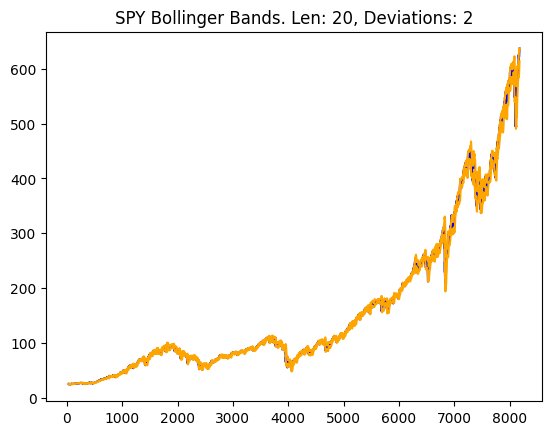

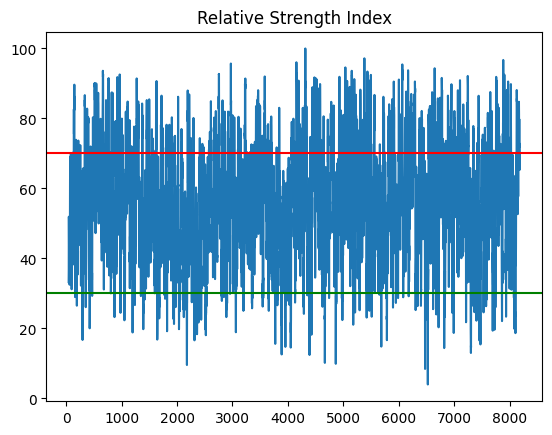

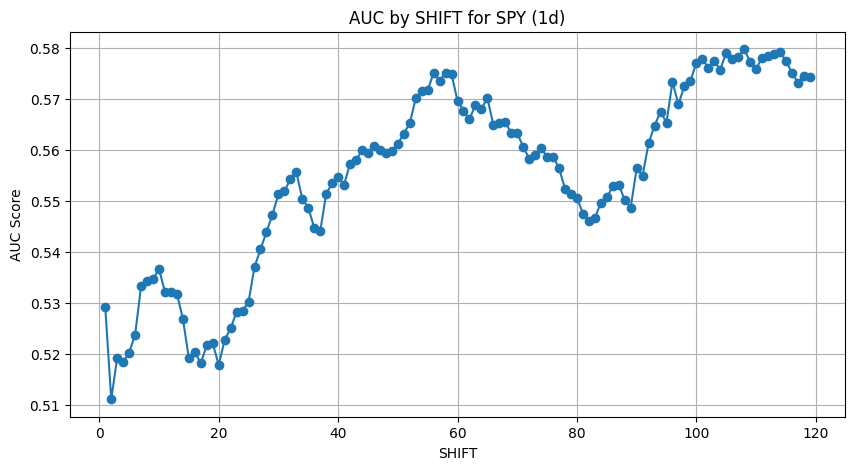


 Optimal SHIFT based on AUC: 108

🔍 Running final model analysis with SHIFT = 108


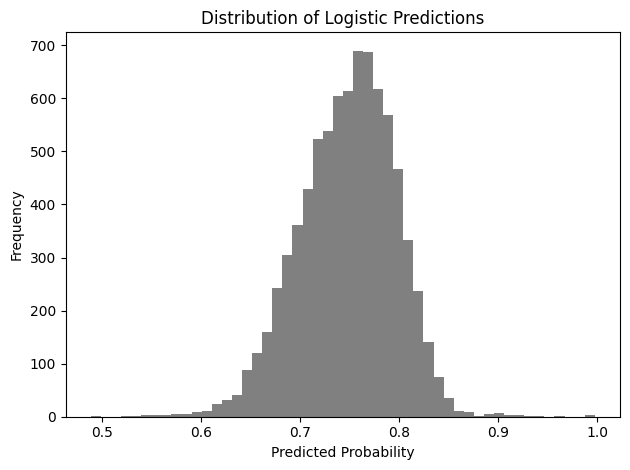

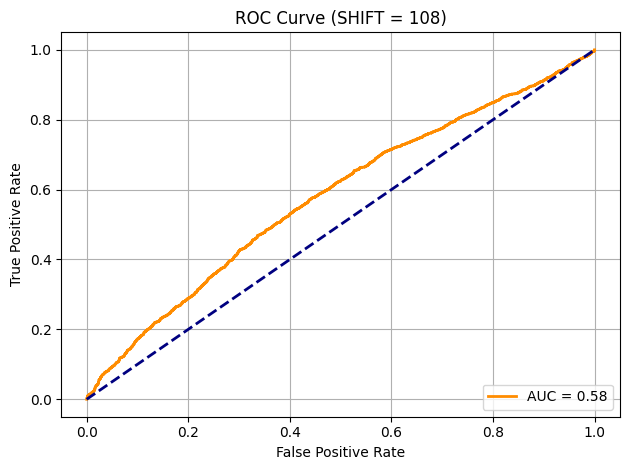

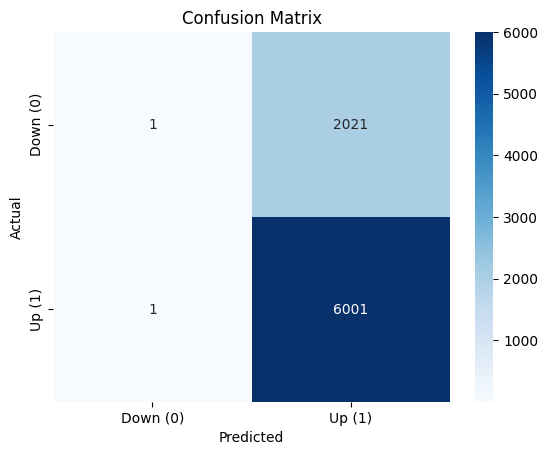

In [ ]:
TICKER = 'SPY'
INTERVAL = '1d'
PERIOD = '730d' if INTERVAL == '1h' else 'max'
SHIFT_RANGE = range(1, 120)
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_LENGTH = 14
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
BB_LEN = 20
DEVS = 2
CUTOFF = .5

LOOKBACK = 10000

STRATEGY = ['Volume_change', 'Close_change', 'High_change', 'Low_change', 'Open_change', 'BB', 'MACD_hist', 'RSI', 'MFI']
OPTIMAL_SHIFT = None

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):
    df = yf.download(ticker, interval=interval, auto_adjust=True, period=PERIOD)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    for c in df.columns:
        df[f'{c}_change'] = df[c].pct_change() * 100

    # only return the subset of data you are interested in
    subset = df.iloc[-lookback:, :]
    plt.figure()
    plt.plot(subset['Close'])
    plt.title(f'Price Movements for {ticker} During Study')

    return subset.dropna()

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df['BB'] = (df['Upper_Band'] - df['Close']) / (df['Upper_Band'] - df['Lower_Band'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_target(df, shift):
    df = df.copy()
    df[f'Close + {shift}'] = df['Close'].shift(-shift)
    df['Target'] = (df[f'Close + {shift}'] > df['Close']).astype(int)
    return df.dropna().reset_index(drop=True)

def generate_regression_output(df, features=STRATEGY, target='Target', cutoff=CUTOFF):
    subset = df[features + [target]].replace([np.inf, -np.inf], np.nan).dropna()

    if len(subset) < 10:
        raise ValueError("Too few rows after cleaning.")

    # Shuffle to break temporal autocorrelation
    subset = subset.sample(frac=1).reset_index(drop=True)

    X = sm.add_constant(subset[features])
    y = subset[target]

    model = sm.Logit(y, X).fit(disp=0)
    y_pred_prob = model.predict(X)

    df = df.loc[subset.index]
    df['Prediction'] = (y_pred_prob > cutoff).astype(int)
    return df, y, y_pred_prob

def add_confusion_matrix(df):
    cm = confusion_matrix(df['Target'], df['Prediction'])
    labels = ['Down (0)', 'Up (1)']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='.0f')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def add_roc_plot(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_prob):
    plt.figure()
    plt.hist(y_pred_prob, bins=50, color='gray')
    plt.title('Distribution of Logistic Predictions')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def explore_shift_auc(df_raw):
    print(f"Exploring AUC over SHIFT range for {TICKER} on {INTERVAL} interval\n")
    results = []

    for shift in SHIFT_RANGE:
        try:
            df = add_target(df_raw.copy(), shift)
            df, y, y_pred_prob = generate_regression_output(df)
            auc_score = roc_auc_score(y, y_pred_prob)
            print(f"Shift: {shift:2d} | AUC: {auc_score:.4f}")
            results.append({'Shift': shift, 'AUC': auc_score})
        except Exception as e:
            print(f"Shift {shift}: Skipped due to error ({e})")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)
    return results_df

def main():
    global OPTIMAL_SHIFT

    # Load and preprocess data once
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)

    # Explore AUC over multiple shifts
    results_df = explore_shift_auc(df)
    plot_df = results_df.sort_values(by='Shift') 

    # Plot AUC vs. Shift
    plt.figure(figsize=(10, 5))
    plt.plot(plot_df['Shift'], plot_df['AUC'], marker='o')
    plt.title(f'AUC by SHIFT for {TICKER} ({INTERVAL})')
    plt.xlabel('SHIFT')
    plt.ylabel('AUC Score')
    plt.grid(True)
    plt.show()

    # Set optimal shift globally for future studies
    OPTIMAL_SHIFT = int(results_df.iloc[0]['Shift'])
    print(f"\n Optimal SHIFT based on AUC: {OPTIMAL_SHIFT}")

    # Final study with optimal shift
    print(f"\n🔍 Running final model analysis with SHIFT = {OPTIMAL_SHIFT}")
    df_final = add_target(df.copy(), shift=OPTIMAL_SHIFT)
    df_final, y_final, y_pred_prob = generate_regression_output(df_final)

    plot_prediction_distribution(y_pred_prob)
    add_roc_plot(y_final, y_pred_prob, title=f'ROC Curve (SHIFT = {OPTIMAL_SHIFT})')
    add_confusion_matrix(df_final)

    return df, results_df

    

# Run
df, results_df = main()